In [1]:
import cv2
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
import copy
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib import patches as patches
import os
import math
from sklearn.cluster import KMeans
from concurrent.futures import ThreadPoolExecutor
import sys

sys.path.append('C:\\Users\\10359\\Desktop\\master\\DIP\\WMR\\src')
from src import *

### Step 1: Watermark Estimation

In [2]:
poisson_reconstruct_grad = False
# threshold = 0.4
KERNEL_SIZE = 3

# 執行GUI程式，透過GUI介面取得matted watermark，可以一張或多張，越多張越準確
matted_watermarks = get_matted_watermark()

# 透過estimate_watermark函數計算出原始水印可能的梯度
matted_watermarks_arr = [np.array(matted_watermark) for matted_watermark in matted_watermarks]
print("Number of photos: ", len(matted_watermarks_arr))
(Wm_x, Wm_y, gx_crops, gy_crops) = estimate_watermark2(matted_watermarks_arr)

# 透過poisson_reconstruct函數計算出原始水印
W_m, _ = poisson_reconstruct3(Wm_x, Wm_y)

# 經過poisson_reconstruct函數重建的水印圖像，再做一次梯度計算(可能)可以得到更準確的梯度
if poisson_reconstruct_grad:
    Wm_x = cv2.Sobel(W_m, cv2.CV_64F, 1, 0, ksize=KERNEL_SIZE)
    Wm_y = cv2.Sobel(W_m, cv2.CV_64F, 0, 1, ksize=KERNEL_SIZE)


est_gradient_avg = np.average(np.sqrt(np.square(Wm_x) + np.square(Wm_y)), axis=2)


# 重建水印圖像的x與y方向梯度
gx_est = cv2.Sobel(W_m, cv2.CV_64F, 1, 0, ksize=1)
gy_est = cv2.Sobel(W_m, cv2.CV_64F, 0, 1, ksize=1)

Number of photos:  3
Computing gradients.
(9, 12) (76, 177)
(5, 4) (72, 169)
Computing median gradients.


(-0.5, 173.5, 74.5, -0.5)

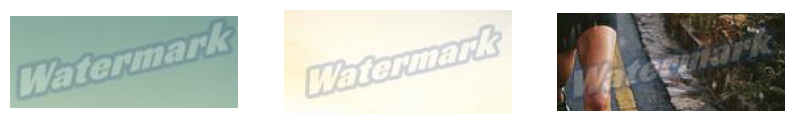

In [14]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(matted_watermarks[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(matted_watermarks[1])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(matted_watermarks[2])
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 164.5, 66.5, -0.5)

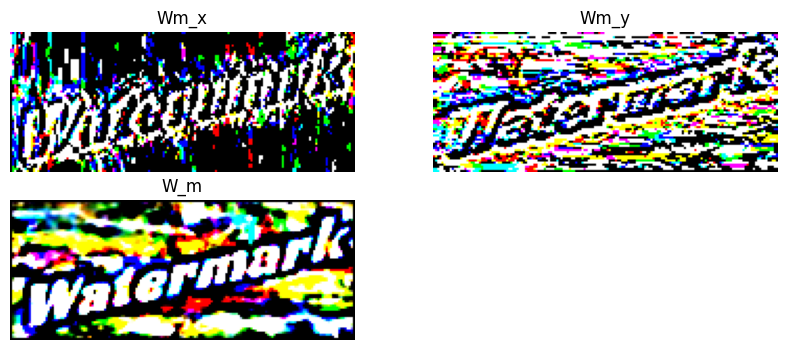

In [15]:
# 顯示重建水印圖像
plt.figure(figsize=(10, 4))

plt.subplot(2, 2, 1)
plt.imshow(Wm_x)
plt.title('Wm_x')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(Wm_y)
plt.title('Wm_y')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(W_m)
plt.title('W_m')
plt.axis('off') 

# plt.subplot(2, 2, 4)
# plt.imshow(PlotImage(image_threshold(W_m, 0.5))*255)

### Step 2: Watermark Detection

Method 1: 直接使用Chamfer distance計算

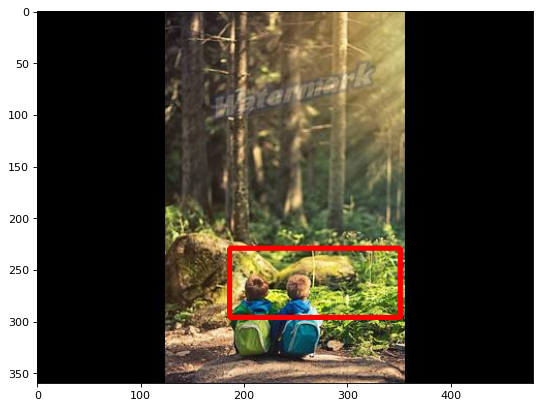

In [4]:
# 肉眼比較難偵測的圖片
# test_img_path = './mountain_real/watermarked_alpha2/istockphoto-1514165009-612x612.jpg'
# test_img_path = './mountain_real/watermarked_alpha2/istockphoto-1445528561-612x612.jpg'
# test_img_path = './mountain_real/watermarked_alpha2/istockphoto-1441762413-612x612.jpg'
# test_img_path = './mountain_real/watermarked_alpha2/istockphoto-1388239619-612x612.jpg'
# test_img_path = './mountain_real/watermarked_alpha2/istockphoto-1360685220-612x612.jpg'
# test_img_path = './mountain_real/watermarked_alpha2/istockphoto-1301767286-612x612.jpg'
# test_img_path = './mountain_real/watermarked_alpha2/istockphoto-1285662078-612x612.jpg'

# 比較難偵測的圖片
test_img_path = './mountain_real/watermarked_alpha2/istockphoto-1316243383-612x612.jpg' #女子
test_img_path = './mountain_real/watermarked_alpha2/istockphoto-516427571-612x612.jpg' #森林
# test_img_path = './mountain_real/watermarked_alpha2/istockphoto-1259152913-612x612.jpg'#雪山

gx_est = cv2.Sobel(W_m, cv2.CV_64F, 1, 0, ksize=1)
gy_est = cv2.Sobel(W_m, cv2.CV_64F, 0, 1, ksize=1)

img = cv2.imread(test_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im, start, end = watermark_detector2(img, gx_est, gy_est, 100, 200)

plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(im)

方法2 : 先用SIFT縮限範圍再使用Chamfer Distance

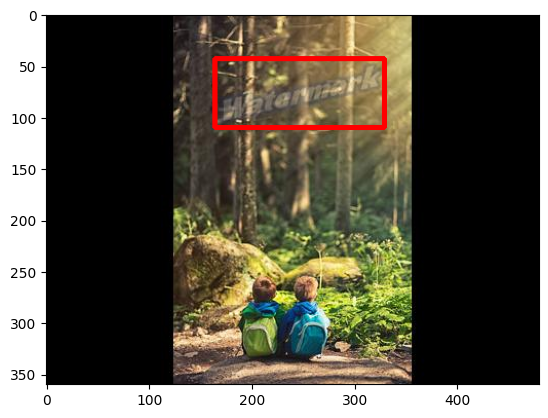

In [5]:
# 特別難找到的圖
# 可能要重新跑幾次才會抓到
img = cv2.imread("./mountain_real/watermarked_alpha2/istockphoto-1259152913-612x612.jpg") #雪山 #channel = '03', iter = 2
img = cv2.imread("./mountain_real/watermarked_alpha2/istockphoto-516427571-612x612.jpg") #森林 #channel = '03', iter = 1
# img = cv2.imread("./mountain_real/watermarked_alpha2/istockphoto-1316243383-612x612.jpg") #女子 #channel = '01', iter = 1
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# watermark_sample = (PlotImage(W_m)*255).astype(np.uint8)

im, start, end, cropped_image = watermark_detector_SIFT(W_m, img, gx_est, gy_est, 100, 200, iter=1, channel='O3')
plt.imshow(im)

### Step3. Watermark decomposition

In [6]:
def plot(img):
    plt.imshow(img.astype(np.uint8))
    plt.show()

Computing gradients.
Computing median gradients.


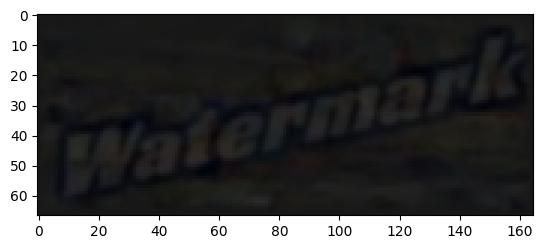

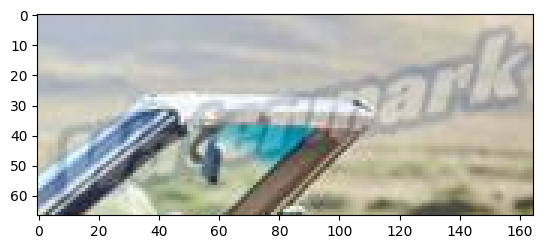

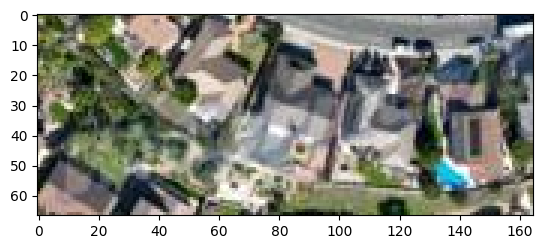

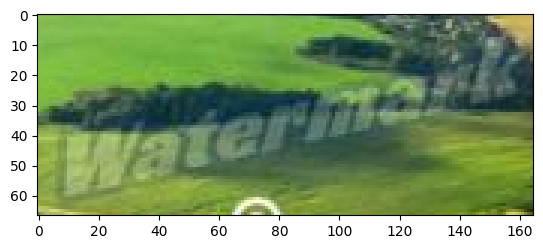

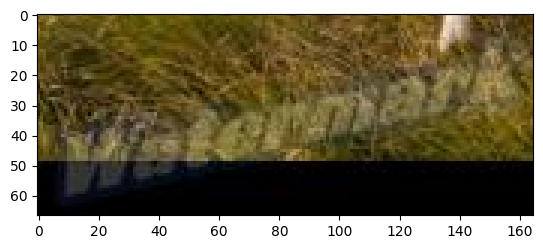

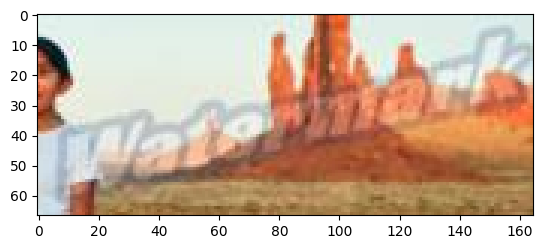

In [7]:
# 設定圖片資料夾的路徑
folder_path = './mountain_real/watermarked_alpha2/'
# 獲取資料夾中所有文件的名稱
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
# 初始化列表，用於儲存每張圖片的處理結果
ims = []
starts = []
ends = []

num_images = 5
image_files = image_files[40:40+num_images]

# 處理每一張圖片
for image_file in image_files:
    img_path = os.path.join(folder_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 假設 watermark_detector 是一個定義好的函數，並且 gx_est, gy_est 已經被定義
    im, start, end = watermark_detector2(img, gx_est, gy_est, 100, 200, draw_rect=False)
    # im, start, end, cropped_image = watermark_detector_SIFT(W_m, img, gx_est, gy_est, 100, 200, iter=1, channel='O1')
    
    # 將負的座標平移至正的座標
    if start[0] < 0:
        diff = -start[0]
        start = (0, start[1])
        end = (end[0]+diff, end[1])
    if start[1] < 0:
        diff = -start[1]
        start = (start[0], 0)
        end = (end[0], end[1]+diff)
    
    # 儲存每張圖片的處理結果
    ims.append(im)
    starts.append(start)
    ends.append(end)
    
# 算出K
K = len(ims)

# 擷取每張圖片中有浮水印得部分J
J = get_cropped_images2(ims, starts, ends)
gx, gy, gxlist, gylist = estimate_watermark_from_J(J)

W_m = poisson_reconstruct(gx, gy)
Wm = W_m - W_m.min() # 平移最小值為0，之後會再shift ∇α·E[Ik]，所以這裡仍不是真正
plot(Wm)
for i in J:
    plot(i)

Estimating normalized alpha using 5 images.
0.28434082906209446
0.28671456515522725
0.3440615076016817
------------------------------------
Iteration: 0
Step 1


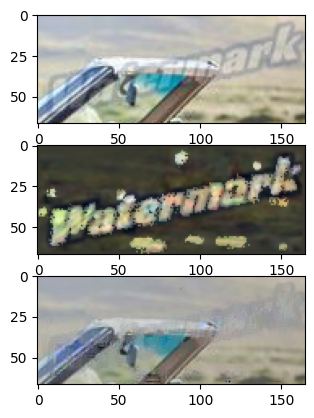

0


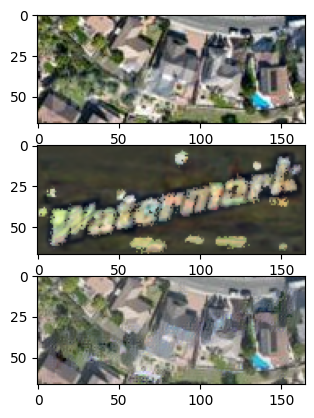

1


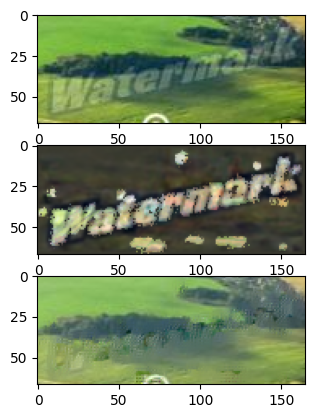

2


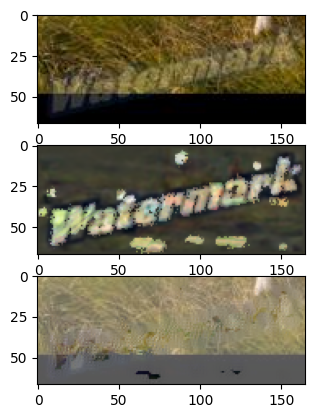

3


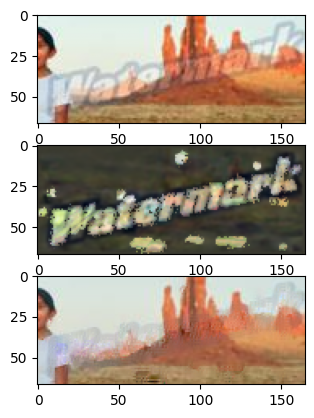

4
Step 2


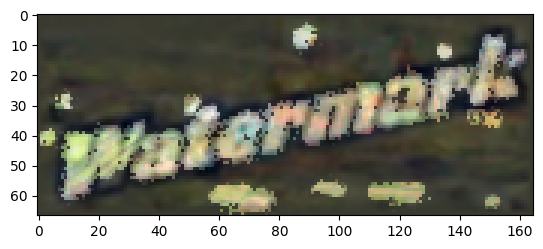

Step 3


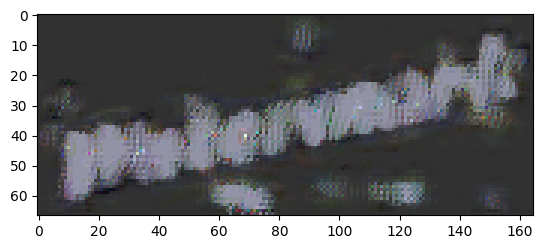

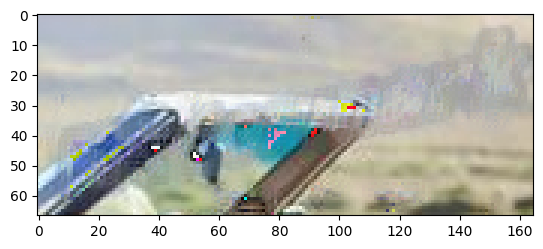

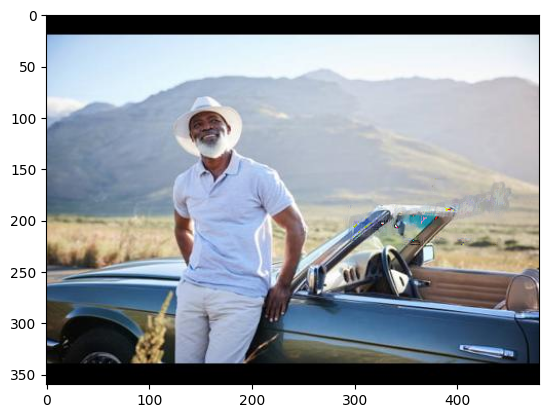

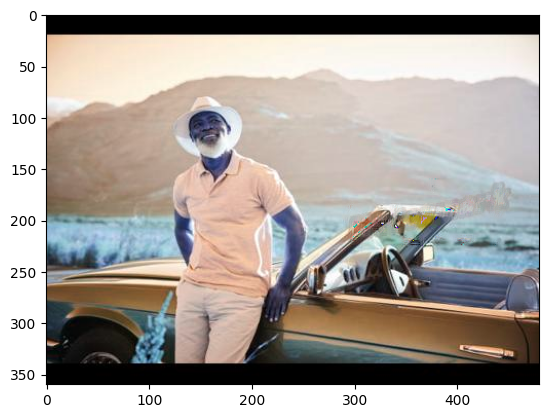

In [8]:
########## step3: watermark decomposition ##########
# get threshold of W_m for alpha matte estimate
# 每張圖每個pixel都有三通道α值，我們可以直接算出αn，並先設定三通道一模一樣，照理說不會有太大差異，所以是最佳化不錯的初始設定
alph_est = estimate_normalized_alpha(J, Wm, K) # 得到αn
alph = np.stack([alph_est, alph_est, alph_est], axis=2) # αn 三通道值一樣

# 求C, blending factor, 一通道一個
C, est_Ik = estimate_blend_factor(J, Wm, alph,2.55)
#C, est_Ik = estimate_blend_factor2(J, Wm, alph,2.55)

# αn * C = α
alpha = alph.copy()
for i in range(3):
	alpha[:,:,i] = C[i]*alpha[:,:,i]

# shift α·E[Ik]
Wm = Wm + alpha*est_Ik

# 三個通道除以C得浮水印本身：Ｗ，也就是blending factor=1的樣子
W = Wm.copy()
for i in range(3):
	W[:,:,i]/=C[i]

# now we have the values of alpha, Wm, J
# Solve for all images
Wk, Ik, W, alpha1 = solve_images(J, W_m, alpha, W, iters=1)
# Ik是我們要的結果
plot(Ik[0])
restored_Ik = restoreImages_dif_loc(ims, Ik, starts, ends)
plot(restored_Ik[0])
image_rgb = cv2.cvtColor(restored_Ik[0], cv2.COLOR_BGR2RGB)
plot(image_rgb)

In [ ]:
output_dir = 'output_dif_loc'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through the list of images
for i, img in enumerate(restored_Ik):
    # Convert from BGR to RGB
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    # Construct the output filename
    output_filename = os.path.join(output_dir, f'image_{i}.png')
        
    # Save the image in the specified folder as PNG
    cv2.imwrite(output_filename, rgb_image)